In [1]:
# import pyro
# import torch
# import torch.tensor as tensor
# import pyro.distributions as dist
# # from torch.distributions import Binomial, Gamma, Uniform
# from pyro.distributions import Binomial, Bernoulli, Categorical, Dirichlet, DirichletMultinomial, Beta, BetaBinomial, Uniform, Gamma, Multinomial

import numpy as np

import scipy
from skopt import gp_minimize 
from scipy.stats import binom as ScipyBinom
from matplotlib import pyplot
import torch
from torch import tensor

from collections import namedtuple
import time
seed = 0

In [26]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
from mvl import genData, likelihoods, bayes
from mvl.likelihoods import getAlphas, getPis

In [230]:
import copy
resSim = {
        "allRes": None,
        "nEpochs": None,
        "bestRes": {
            "pis": None,
            "alphas": None,
            "PDV_c1true": None,
            "PDV_c2true": None,
            "PDV_cBothTrue": None,
            "PDV_c1inferred": None,
            "PDV_c2inferred": None,
            "PDV_cBothInferred": None,
        }
    }

cached6NormalSimRes = []

rrsSim = tensor([[2, 2, 1.5]])
pisSim = tensor([[.05, .05, .05]])

nCases = tensor([15e3, 15e3, 6e3])
nCtrls = tensor(5e5)
i = 0
for rrsSimRun in rrsSim:
    for pisSimRun in pisSim:
        afMeanRun = 1e-4
        generatingFn = genData.v6normal
        # In DSB:
        # 	No ID	ID	
        #         ASD+ADHD	684	217	
        #         ASD	3091	871	
        #         ADHD	3206	271	
        #         Control	5002	-	

        #         gnomAD	44779	(Non-Finnish Europeans in non-psychiatric exome subset)	

        #         Case total:	8340		
        #         Control total:	49781		
        # so we can use pDBoth = .1 * total_cases
        # needs tensor for shapes, otherwise "gamma_cpu not implemente for long", e.g rrShape=50.0 doesn't work...
        paramsRun = genData.genParams(rrMeans=rrsSimRun, pis=pisSimRun, afMean=afMeanRun, rrShape=tensor(50.), afShape=tensor(50.), nCases=nCases, nCtrls=nCtrls)[0]
        
        pDsRun = paramsRun["pDs"]
        pisRun = paramsRun["diseaseFractions"]
        print("params are:", paramsRun)
        
        cached6NormalSimRes.append({"params": paramsRun, "runs": []})
        for y in range(0, 10):
            start = time.time()
            r = generatingFn(**paramsRun)
            print("took", time.time() - start)
            
            resPointer = {
                **r,
                "generatingFn": generatingFn,
                "results": None,
            }

            cached6NormalSimRes[i]["runs"].append(resPointer)
            
            print(f"Run: {i}, {y}")
            
            xsRun = resPointer["altCounts"]
            afsRun = resPointer["afs"]
            affectedGenesRun = resPointer["affectedGenes"]
            unaffectedGenesRun = resPointer["unaffectedGenes"]

            runCostFnIdx = 16

            nEpochsRun = 10
            print("nEpochsRun", nEpochsRun)
            
            res = likelihoods.fitFnBivariateAnnealing(xsRun, pDsRun, nEpochs=nEpochsRun, minLLThresholdCount=20, debug=True, costFnIdx=runCostFnIdx)
            bestRes = res["params"][-1]

            inferredPis = tensor(bestRes[0:3]) # 3-vector
            inferredAlphas = tensor(bestRes[3:]) # 4-vector, idx0 is P(!D|V)

            #### Calculate actual ###
            component1Afs = afsRun[affectedGenesRun[0]]
            c1true = (component1Afs / afMeanRun).mean(0)

            component2Afs = afsRun[affectedGenesRun[1]]
            c2true = (component2Afs / afMeanRun).mean(0)

            componentBothAfs = afsRun[affectedGenesRun[2]]
            cBothTrue = (componentBothAfs / afMeanRun).mean(0)

            ### calculate inferred values
            pds = tensor([1-pDsRun.sum(), *pDsRun])
            alphas = inferredAlphas.numpy()
            c1inferred = Dirichlet(tensor([alphas[0], alphas[1], alphas[0], alphas[2]]) * pds).sample([10_000]).mean(0)
            c2inferred = Dirichlet(tensor([alphas[0], alphas[0], alphas[2], alphas[2]]) * pds).sample([10_000]).mean(0)
            cBothInferred = Dirichlet(tensor([alphas[0], (alphas[1] + alphas[3]), (alphas[2] + alphas[3]), (alphas[1] + alphas[2] + alphas[3])]) * pds).sample([10_000]).mean(0)

            print(f"\n\nrun {i} results for rrs: {rrsSimRun}, pis: {pisSimRun}")
            print("Inferred pis:", inferredPis)
            print("\nP(D|V) true ans in component 1:", c1true)
            print("P(D|V) inferred in component 1:", c1inferred)
            print("\nP(D|V) true ans in component 1:", c2true)
            print("P(D|V) inferred in component both:", c2inferred)
            print("\nP(D|V) true ans in component both:", cBothTrue)
            print("P(D|V) inferred in component both:", cBothInferred,"\n\n")

            resToStore = copy.deepcopy(resSim)
            resToStore["allRes"] = res
            resToStore["nEpochs"] = nEpochsRun
            br = resToStore["bestRes"]
            br["pis"] = inferredPis
            br["alphas"] = inferredAlphas
            br["PDV_c1true"] = c1true
            br["PDV_c2true"] = c2true
            br["PDV_cBothTrue"] = cBothTrue
            br["PDV_c1inferred"] = c1inferred
            br["PDV_c2inferred"] = c2inferred
            br["PDV_cBothInferred"] = cBothInferred

            resPointer["results"] = resToStore
        
        i += 1

pDs are: tensor([0.0280, 0.0280, 0.0112])
covShared is tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]])
params are: {'nGenes': 20000, 'nCases': tensor([15000., 15000.,  6000.]), 'nCtrls': tensor(500000.), 'pDs': tensor([0.0280, 0.0280, 0.0112]), 'diseaseFractions': tensor([0.0500, 0.0500, 0.0500]), 'rrShape': tensor(50.), 'rrMeans': tensor([2.0000, 2.0000, 1.5000]), 'afShape': tensor(50.), 'afMean': 0.0001, 'covShared': tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]]), 'covSingle': tensor([[1, 0],
        [0, 1]])}


NameError: name 'rrShape' is not defined

In [ ]:
import copy
resSim = {
        "allRes": None,
        "nEpochs": None,
        "bestRes": {
            "pis": None,
            "alphas": None,
            "PDV_c1true": None,
            "PDV_c2true": None,
            "PDV_cBothTrue": None,
            "PDV_c1inferred": None,
            "PDV_c2inferred": None,
            "PDV_cBothInferred": None,
        }
    }

cached6NormalSimResNonAnnealing = []

rrsSim = tensor([[2, 2, 1.5]])
pisSim = tensor([[.05, .05, .05]])

nCases = tensor([15e3, 15e3, 6e3])
nCtrls = tensor(5e5)
i = 0
for rrsSimRun in rrsSim:
    for pisSimRun in pisSim:
        afMeanRun = 1e-4
        generatingFn = genData.v6normal
        # In DSB:
        # 	No ID	ID	
        #         ASD+ADHD	684	217	
        #         ASD	3091	871	
        #         ADHD	3206	271	
        #         Control	5002	-	

        #         gnomAD	44779	(Non-Finnish Europeans in non-psychiatric exome subset)	

        #         Case total:	8340		
        #         Control total:	49781		
        # so we can use pDBoth = .1 * total_cases
        # needs tensor for shapes, otherwise "gamma_cpu not implemente for long", e.g rrShape=50.0 doesn't work...
        paramsRun = genData.genParams(rrMeans=rrsSimRun, pis=pisSimRun, afMean=afMeanRun, rrShape=tensor(50.), afShape=tensor(50.), nCases=nCases, nCtrls=nCtrls)[0]
        
        pDsRun = paramsRun["pDs"]
        pisRun = paramsRun["diseaseFractions"]
        print("params are:", paramsRun)
        
        cached6NormalSimResNonAnnealing.append({"params": paramsRun, "runs": []})
        for y in range(0, 10):
            start = time.time()
            r = generatingFn(**paramsRun)
            print("took", time.time() - start)
            
            resPointer = {
                **r,
                "generatingFn": generatingFn,
                "results": None,
            }

            cached6NormalSimResNonAnnealing[i]["runs"].append(resPointer)
            
            print(f"Run: {i}, {y}")
            
            xsRun = resPointer["altCounts"]
            afsRun = resPointer["afs"]
            affectedGenesRun = resPointer["affectedGenes"]
            unaffectedGenesRun = resPointer["unaffectedGenes"]

            runCostFnIdx = 16

            nEpochsRun = 10
            print("nEpochsRun", nEpochsRun)
            
            res = likelihoods.fitFnBivariate(xsRun, pDsRun, nEpochs=nEpochsRun, minLLThresholdCount=20, debug=True, costFnIdx=runCostFnIdx)
            bestRes = res["params"][-1]

            inferredPis = tensor(bestRes[0:3]) # 3-vector
            inferredAlphas = tensor(bestRes[3:]) # 4-vector, idx0 is P(!D|V)

            #### Calculate actual ###
            component1Afs = afsRun[affectedGenesRun[0]]
            c1true = (component1Afs / afMeanRun).mean(0)

            component2Afs = afsRun[affectedGenesRun[1]]
            c2true = (component2Afs / afMeanRun).mean(0)

            componentBothAfs = afsRun[affectedGenesRun[2]]
            cBothTrue = (componentBothAfs / afMeanRun).mean(0)

            ### calculate inferred values
            pds = tensor([1-pDsRun.sum(), *pDsRun])
            alphas = inferredAlphas.numpy()
            c1inferred = Dirichlet(tensor([alphas[0], alphas[1], alphas[0], alphas[2]]) * pds).sample([10_000]).mean(0)
            c2inferred = Dirichlet(tensor([alphas[0], alphas[0], alphas[2], alphas[2]]) * pds).sample([10_000]).mean(0)
            cBothInferred = Dirichlet(tensor([alphas[0], (alphas[1] + alphas[3]), (alphas[2] + alphas[3]), (alphas[1] + alphas[2] + alphas[3])]) * pds).sample([10_000]).mean(0)

            print(f"\n\nrun {i} results for rrs: {rrsSimRun}, pis: {pisSimRun}")
            print("Inferred pis:", inferredPis)
            print("\nP(D|V) true ans in component 1:", c1true)
            print("P(D|V) inferred in component 1:", c1inferred)
            print("\nP(D|V) true ans in component 1:", c2true)
            print("P(D|V) inferred in component both:", c2inferred)
            print("\nP(D|V) true ans in component both:", cBothTrue)
            print("P(D|V) inferred in component both:", cBothInferred,"\n\n")

            resToStore = copy.deepcopy(resSim)
            resToStore["allRes"] = res
            resToStore["nEpochs"] = nEpochsRun
            br = resToStore["bestRes"]
            br["pis"] = inferredPis
            br["alphas"] = inferredAlphas
            br["PDV_c1true"] = c1true
            br["PDV_c2true"] = c2true
            br["PDV_cBothTrue"] = cBothTrue
            br["PDV_c1inferred"] = c1inferred
            br["PDV_c2inferred"] = c2inferred
            br["PDV_cBothInferred"] = cBothInferred

            resPointer["results"] = resToStore
        
        i += 1

In [ ]:
runSim()

In [ ]:
runSim(fitMethod='nelder-mead')

In [ ]:
res = np.load("./mvln-sim-mvln.npy", allow_pickle=True)


In [ ]:
resByParams = []
for runSet in res:
    params = (runSet["params"]["diseaseFractions"], runSet["params"]["rrMeans"], runSet["params"]["rrShape"])
#     print("param", params)
    res = []
#     if params not in resByParam:
#         resByParams[params] = []
    
    for run in runSet["runs"]:
        if run is None or "results" not in run or run["results"] is None:
            print(f"no results found for {params}")
            continue
        res.append(run["results"])
    resByParams.append([params, res])

np.save("mvln-sim-mvln-results2", resByParams)


In [27]:
resByParams = np.load("mvln-sim-mvln-results.npy", allow_pickle=True)


In [ ]:
resByParams

In [9]:

# plt.subplot([1,len(resByParams)])
i = 0
with open("mvln-sim-mvln-res.tsv", "w") as file:
    file.write(f"Notes: 15000 samples1, 15000 samples2, 6000 samplesBoth; rrs generated from normal distribution with. 1 variance, .4 covariance, and individual effect rr summed with shared-effect rr in genes affecting both conditions\n")
    file.write(f"\tmean\tstd\n")
    for res in resByParams:
        i += 1

        paramsRun = res[0]
        resRun = res[1]

        pis = tensor([x["bestRes"]["pis"].numpy() for x in resRun])
        PDV_c1true = tensor([x["bestRes"]["PDV_c1true"].numpy() for x in resRun])
        PDV_c2true = tensor([x["bestRes"]["PDV_c2true"].numpy() for x in resRun])
        PDV_c3true = tensor([x["bestRes"]["PDV_cBothTrue"].numpy() for x in resRun])
        PDV_c1inferred = tensor([x["bestRes"]["PDV_c1inferred"].numpy() for x in resRun])
        PDV_c2inferred = tensor([x["bestRes"]["PDV_c2inferred"].numpy() for x in resRun])
        PDV_c3inferred = tensor([x["bestRes"]["PDV_cBothInferred"].numpy() for x in resRun])

        file.write(f"\n\ntrue params: \t{paramsRun} \n\n")

        file.write(f"pi\t {pis.mean(0).numpy()} \t  {pis.std(0).numpy()} \n")

        file.write(f"PDV_c1inferred \t {PDV_c1inferred.mean(0).numpy()}\t {PDV_c1inferred.std(0).numpy()}\n")
        file.write(f"PDV_c1true \t {PDV_c1true.mean(0).numpy()} \t {PDV_c1true.std(0).numpy()}\n")
        file.write(f"PDV_c2inferred \t {PDV_c2inferred.mean(0).numpy()} \t {PDV_c2inferred.std(0).numpy()}\n")
        
        file.write(f"PDV_c2true \t {PDV_c2true.mean(0).numpy()} \t {PDV_c2true.std(0).numpy()}\n")
        
        file.write(f"PDV_c3inferred \t {PDV_c3inferred.mean(0).numpy()} \t {PDV_c3inferred.std(0).numpy()}\n")
        
        file.write(f"PDV_c3true \t {PDV_c3true.mean(0).numpy()} \t {PDV_c3true.std(0).numpy()}\n")

    #     plt.figure(i)
    #     plt.plot(t, s1)
    #     plt.plot(t, 2*s1)
        # plt.subplot(222)
        # plt.plot(t, 2*s1)

In [ ]:
with open('./mvln-sim-mvn.json', 'w') as outfile:
    json.dump(cached6NormalSimRes, outfile)

In [22]:
def one(a, b, c, d = 5):
    print(a, b, c, d)
    
def two(*args, **kwargs):
    one(*args, **kwargs)
    
two(1, 2, c = 3)

1 2 3 5


In [ ]:
pool_size = multiprocessing.cpu_count()
os.system('taskset -cp 0-%d %s' % (pool_size, os.getpid()))

genData.runSim(fitMethod="nelder-mead", mt=True)

In [1]:
import os
os.system('taskset -p %s' %os.getpid())

32512

In [ ]:
import multiprocessing
import numpy as np
import math
import time
import os

def compute_something(t):
    a = 0.
    for i in range(10000000):
        a = math.sqrt(t)
    return a




print("Pool size:", pool_size)
pool = multiprocessing.Pool(processes=pool_size)

inputs = range(10)

tic = time.time()
builtin_outputs = map(compute_something, inputs)
print('Built-in:', time.time() - tic)

tic = time.time()
pool_outputs = pool.map(compute_something, inputs)
print('Pool    :', time.time() - tic)

In [ ]:
# import torch 
# import pyro
# from torch.multiprocessing import Process
# from torch.distributions import Uniform
# import time
# import numpy as np
# def writer():
#     message = f"I am Process {i}"
#     print(torch.utils.data.get_worker_info())
#     x = np.random.seed()
#     x = np.random.randint(1000)
#     print('seed', x)
#     torch.manual_seed(x)
#     pis = Uniform(1/100, .5).rsample([3])
#     print("r is", pis)
#     time.sleep(1)

# def reader(i,q):
#     message = q.get()
#     print("got message", message)

# for i in range(10):
   
#     Process(target=writer, args=()).start()
#     time.sleep(.5)
#    # Create multiprocessing pool
#     p = Pool(10)
#    # Create a group of parallel readers and start them
#    # Number of readers is matching the number of writers
#    # However, the number of simultaneously running
#    # readers is constrained to the pool size
#     readers = []
#     for i in range(10):
#         readers.append(p.apply_async(reader, (i,q,)))
#     # Wait for the asynchrounous reader threads to finish
#     [r.get() for r in readers]
    
    
#     # Establish communication queues
#     tasks = torch.multiprocessing.JoinableQueue()
#     results = torch.multiprocessing.Queue()
    
#     # Start consumers
#     num_consumers = torch.multiprocessing.cpu_count()
#     print('Creating %d consumers' % num_consumers)
#     consumers = [ Consumer(tasks, results)
#                   for i in range(num_consumers) ]
#     for w in consumers:
#         w.start()
    
#     # Enqueue jobs
#     for i in range(nEpochs):
#         tasks.put(Task(altCountsByGene, pDs, 1, minLLThresholdCount, K, debug, costFnIdx, method))
    
#     # Add a poison pill for each consumer
#     for i in range(nEpochs):
#         tasks.put(None)

#     # Wait for all of the tasks to finish
#     tasks.join()
    
#     # Start printing results
#     while nEpochs:
#         result = results.get()
#         print('Result:', result)
#         num_jobs -= 1


In [5]:
import os
from collections import defaultdict
import torch
import numpy as np
import scipy.stats
from torch.distributions import constraints
from matplotlib import pyplot
%matplotlib inline

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

smoke_test = ('CI' in os.environ)
pyro.enable_validation(True)

AssertionError: 

In [ ]:
genData.runSim(fitMethod="nelder-mead", mt=True)

In [49]:
from pyro.distributions import DirichletMultinomial

In [50]:
DirichletMultinomial(total_count=1000, concentration=[1, 1, 1, 1]).log_prob([10, 10, 10, 10.])

AttributeError: 'list' object has no attribute 'dtype'

In [4]:
rrs = tensor([3, 3, 1.5])
pis = tensor([.05, .05, .05])
nCases = tensor([10e3, 10e3, 4e3])
nCtrls = tensor(3e5)
afMean = 1e-4
rrShape=tensor(50.)
afShape=tensor(50.)
generatingFn =  genData.v6normal
fitMethod = 'nelder-mead'
nEpochs=20
mt = True
covShared=tensor([[1,.4,.4], [.4, 1, .4], [.4, .4, 1]])
covSingle=tensor([[1, 0], [0, 1]])

try:
    params = genData.genParams(rrMeans=rrs, pis=pis, afMean=afMean, rrShape=rrShape, afShape=afShape, nCases=nCases, nCtrls=nCtrls, covShared=covShared, covSingle=covSingle)[0]
    testData = generatingFn(**params)
except Exception as e:
    print(f"Run failed: {e}")

pDs are: tensor([0.0309, 0.0309, 0.0123])
covShared is tensor([[1.0000, 0.4000, 0.4000],
        [0.4000, 1.0000, 0.4000],
        [0.4000, 0.4000, 1.0000]])
TESTING WITH: nCases tensor([10000., 10000.,  4000.]) nCtrls tensor(300000.) rrMeans tensor([5, 5, 2]) afMean 0.0001 afShape tensor(50.) diseaseFractions tensor([0.0500, 0.0500, 0.0500]) pDs tensor([0.0309, 0.0309, 0.0123]) covShared tensor([[1.0000, 0.4000, 0.4000],
        [0.4000, 1.0000, 0.4000],
        [0.4000, 0.4000, 1.0000]]) covSingle tensor([[1, 0],
        [0, 1]])


test tensor 1.0,0.4,0.4,0.4,1.0,0.4,0.4,0.4,1.0
rrsShared tensor([[ 5.0661,  5.6053, 10.9898],
        [ 5.3634,  6.4503, 12.0233],
        [ 7.1001,  6.4278, 11.2686],
        ...,
        [ 6.2617,  6.6172, 11.4258],
        [ 8.5029,  9.4523, 12.9413],
        [ 6.5320,  3.7719,  9.9317]], dtype=torch.float64) means tensor([ 7.0003,  7.0104, 12.0012], dtype=torch.float64)
rrShared correlation 1 & 2 [[1.         0.40288681]
 [0.40288681 1.        ]]
rrSh

In [5]:
rrsLarge = tensor([5, 5, 5])

try:
    paramsLarge = genData.genParams(rrMeans=rrsLarge, pis=pis, afMean=afMean, rrShape=rrShape, afShape=afShape, nCases=nCases, nCtrls=nCtrls, covShared=covShared, covSingle=covSingle)[0]
    testDataLarge = generatingFn(**paramsLarge)
except Exception as e:
    print(f"Run failed: {e}")

pDs are: tensor([0.0309, 0.0309, 0.0123])
covShared is tensor([[1.0000, 0.4000, 0.4000],
        [0.4000, 1.0000, 0.4000],
        [0.4000, 0.4000, 1.0000]])
TESTING WITH: nCases tensor([10000., 10000.,  4000.]) nCtrls tensor(300000.) rrMeans tensor([5, 5, 5]) afMean 0.0001 afShape tensor(50.) diseaseFractions tensor([0.0500, 0.0500, 0.0500]) pDs tensor([0.0309, 0.0309, 0.0123]) covShared tensor([[1.0000, 0.4000, 0.4000],
        [0.4000, 1.0000, 0.4000],
        [0.4000, 0.4000, 1.0000]]) covSingle tensor([[1, 0],
        [0, 1]])


test tensor 1.0,0.4,0.4,0.4,1.0,0.4,0.4,0.4,1.0
rrsShared tensor([[ 9.5257, 11.5232, 14.1311],
        [10.7909,  9.9036, 15.5301],
        [ 9.7030, 10.4387, 15.0753],
        ...,
        [ 7.8557, 10.6795, 14.3151],
        [10.7741,  9.5019, 13.6796],
        [ 9.1770,  9.9019, 15.5295]], dtype=torch.float64) means tensor([ 9.9887,  9.9992, 14.9990], dtype=torch.float64)
rrShared correlation 1 & 2 [[1.         0.39897117]
 [0.39897117 1.        ]]
rrSh

In [38]:
params

{'nGenes': 20000,
 'nCases': tensor([10000., 10000.,  4000.]),
 'nCtrls': tensor(300000.),
 'pDs': tensor([0.0309, 0.0309, 0.0123]),
 'diseaseFractions': tensor([0.0500, 0.0500, 0.0500]),
 'rrShape': tensor(50.),
 'rrMeans': tensor([3.0000, 3.0000, 1.5000]),
 'afShape': tensor(50.),
 'afMean': 0.0001,
 'covShared': tensor([[1, 0, 0],
         [0, 1, 0],
         [0, 0, 1]]),
 'covSingle': tensor([[1, 0],
         [0, 1]])}

In [168]:
testFit = likelihoods.fitFnBivariate(testData["altCounts"], params["pDs"], nEpochs=1)

torch.Size([20000, 4])
pdCtrl, pd1, pd2, pdBoth:  tensor([0.9259, 0.0309, 0.0309, 0.0123], dtype=torch.float64)
method nelder-mead costFn <function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7f9589d62cb0>
best ll: 74255.85016436226, bestParams: [0.096755035, 0.077788964, 0.07774635, 10181.05, 19670.508, 15529.679, 18778.402]
Epoch took 239.9891939163208


In [98]:
testFitLarge = likelihoods.fitFnBivariateDirichletPrior(testDataLarge["altCounts"], paramsLarge["pDs"], nEpochs=1)

torch.Size([20000, 4])
IN: altCountsFlat torch.Size([20000, 4])
pdCtrl, pd1, pd2, pdBoth:  tensor([0.9259, 0.0309, 0.0309, 0.0123], dtype=torch.float64)
method nelder-mead costFn <function likelihoodBivariateFastDirichletPrior.<locals>.jointLikelihood at 0x7f9462eac170>
best ll: 92691.0863548453, bestParams: [0.27823806, 0.04133299, 0.2784639, 0.4019651, 2994.2, 24282.08, 22942.201, 21544.13]
Epoch took 1819.2030441761017


In [103]:
testFitLarge["trajectoryPi"][-1]

tensor([8.6943e-01, 1.4185e-30, 2.8410e-02, 1.0216e-01], dtype=torch.float64)

In [104]:
testFitLarge = likelihoods.fitFnBivariate(testDataLarge["altCounts"], paramsLarge["pDs"], nEpochs=1)

torch.Size([20000, 4])
IN: altCountsFlat torch.Size([20000, 4])
pdCtrl, pd1, pd2, pdBoth:  tensor([0.9259, 0.0309, 0.0309, 0.0123], dtype=torch.float64)
method nelder-mead costFn <function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7f9462f167a0>
best ll: 86199.81644286908, bestParams: [0.019615324, 0.10174057, 0.04452867, 1105.324, 5292.936, 10853.965, 24484.887]
Epoch took 61.06230902671814


In [105]:
testFitLarge["params"]

[array([4.69343876e-02, 4.52490511e-02, 4.99383689e-02, 1.58547345e+02,
        1.00704468e+03, 1.05688709e+03, 6.65327200e+03])]

In [169]:
testFit["params"]

[array([4.96700407e-02, 4.63871772e-02, 3.99195082e-02, 3.74160080e+02,
        8.27225743e+02, 8.64313147e+02, 7.68432063e+02])]

In [289]:
testFitLarge["params"]

[array([4.63864639e-02, 4.03900172e-02, 3.97658043e-02, 1.70694632e+02,
        1.10274908e+03, 1.18464482e+03, 7.13244313e+03])]

In [170]:
testFit.keys()

dict_keys(['lls', 'llsAll', 'params', 'trajectoryLLs', 'trajectoryPi', 'trajectoryAlphas'])

In [171]:
ta = tensor(testFit["trajectoryAlphas"])

In [110]:
taLarge = tensor(testFitLarge["trajectoryAlphas"])

In [112]:
bestLL = None
bestParams = None
for x in testFit:
    if bestLL is None or x["lls"][0] < bestLL:
        bestParams = x["params"][0]
        bestLL = x["lls"][0]
    

TypeError: string indices must be integers

In [107]:
pyplot.plot(testFit["trajectoryLLs"])

NameError: name 'testFit' is not defined

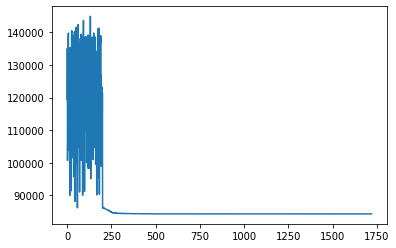

In [108]:
pyplot.plot(testFitLarge["trajectoryLLs"])

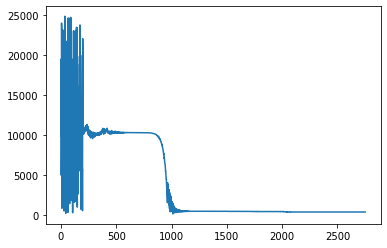

In [173]:
pyplot.plot(ta[:,0])

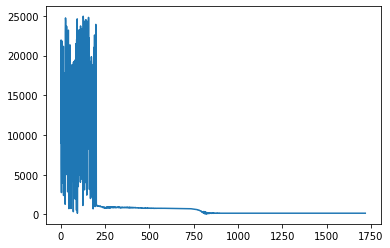

In [111]:
pyplot.plot(taLarge[:,0])

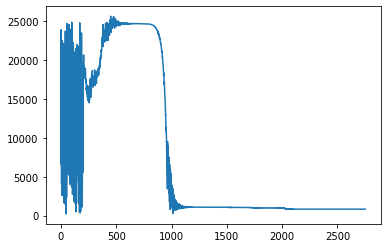

In [174]:
pyplot.plot(ta[:,1])

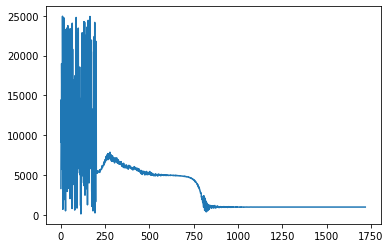

In [112]:
pyplot.plot(taLarge[:,1])

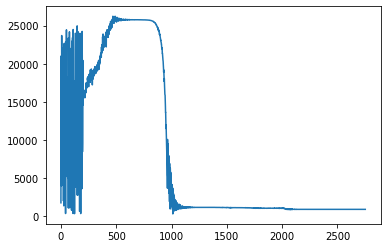

In [175]:
pyplot.plot(ta[:,2])

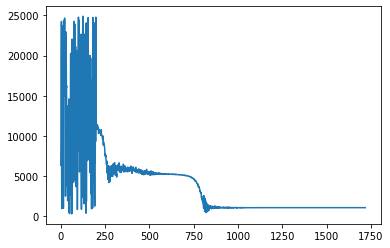

In [113]:
pyplot.plot(taLarge[:,2])

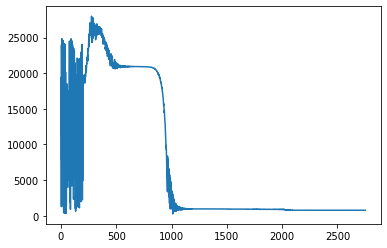

In [176]:
pyplot.plot(ta[:,3])

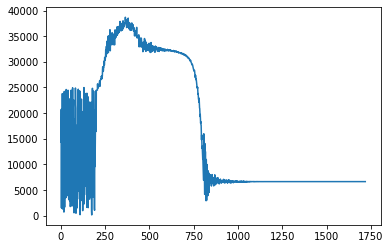

In [114]:
pyplot.plot(taLarge[:,3])

In [296]:
pisTraj = tensor(testFit["trajectoryPi"])


In [115]:
pisTrajLarge = tensor(testFitLarge["trajectoryPi"])

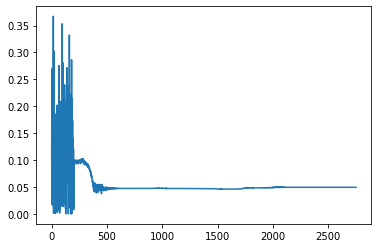

In [178]:
pyplot.plot(pisTraj[:,0])

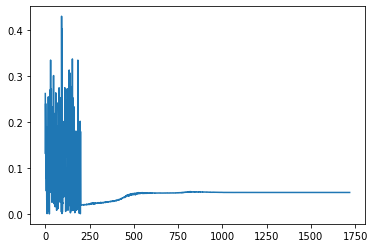

In [116]:
pyplot.plot(pisTrajLarge[:,0])

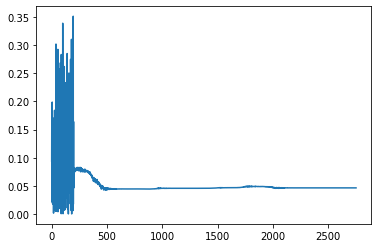

In [179]:
pyplot.plot(pisTraj[:,1])

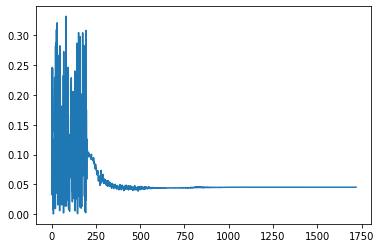

In [117]:
pyplot.plot(pisTrajLarge[:,1])

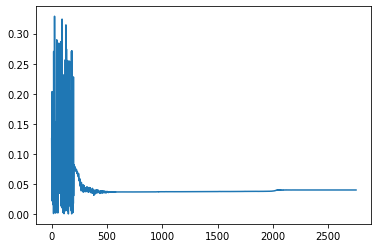

In [180]:
pyplot.plot(pisTraj[:,2])

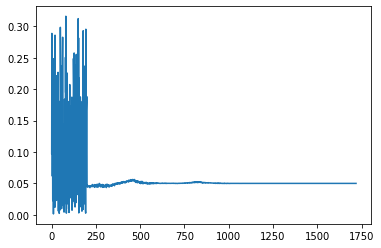

In [118]:
pyplot.plot(pisTrajLarge[:,2])

In [126]:
testCounts = testData["altCounts"]
testCountsLarge = testDataLarge["altCounts"]
testCountsLarge

tensor([[31.,  5.,  1.,  6.],
        [27.,  4.,  1.,  2.],
        [27.,  6.,  0.,  3.],
        ...,
        [35.,  0.,  3.,  1.],
        [30.,  2.,  3.,  0.],
        [28.,  0.,  1.,  0.]], dtype=torch.float64)

In [129]:
len(testDataLarge["affectedGenes"])

3

In [123]:
paramsLarge

{'nGenes': 20000,
 'nCases': tensor([10000., 10000.,  4000.]),
 'nCtrls': tensor(300000.),
 'pDs': tensor([0.0309, 0.0309, 0.0123]),
 'diseaseFractions': tensor([0.0500, 0.0500, 0.0500]),
 'rrShape': tensor(50.),
 'rrMeans': tensor([5, 5, 5]),
 'afShape': tensor(50.),
 'afMean': 0.0001,
 'covShared': tensor([[1.0000, 0.4000, 0.4000],
         [0.4000, 1.0000, 0.4000],
         [0.4000, 0.4000, 1.0000]]),
 'covSingle': tensor([[1, 0],
         [0, 1]])}

In [125]:
testFitLarge["params"]

[array([4.69343876e-02, 4.52490511e-02, 4.99383689e-02, 1.58547345e+02,
        1.00704468e+03, 1.05688709e+03, 6.65327200e+03])]

In [136]:
pdgivenVestimateLarge = likelihoods.inferPDGivenVfromAlphas(tensor(testFitLarge["params"][0][3:]), pds=paramsLarge["pDs"])
print("est:", pdgivenVestimateLarge)
truePDGivenV = likelihoods.empiricalPDGivenV(testDataLarge["afs"], affectedGenes=testDataLarge["affectedGenes"],truePV=paramsLarge["afMean"])
print("tru:", truePDGivenV)

est: (tensor([0.7494, 0.1588, 0.0251, 0.0668], dtype=torch.float64), tensor([0.7437, 0.0250, 0.1650, 0.0662], dtype=torch.float64), tensor([0.2016, 0.3244, 0.3263, 0.1477], dtype=torch.float64))
tru: (tensor([0.7578, 0.1547, 0.0310, 0.0619], dtype=torch.float64), tensor([0.7549, 0.0310, 0.1550, 0.0620], dtype=torch.float64), tensor([0.1940, 0.3081, 0.3080, 0.1848], dtype=torch.float64))


IN: altCountsFlat torch.Size([50000, 4])
pdCtrl, pd1, pd2, pdBoth:  tensor([0.9259, 0.0309, 0.0309, 0.0123], dtype=torch.float64)
alphas tensor([ 158.5473, 1007.0447, 1056.8871, 6653.2720], dtype=torch.float64)
nullLikes tensor([0.0909, 0.0939, 0.0909,  ..., 0.0939, 0.0852, 0.0470])
effectLikes tensor([[2.0329e-04, 9.7812e-04, 2.7822e-20],
        [1.1079e-03, 8.3923e-04, 1.1534e-18],
        [2.0329e-04, 9.7812e-04, 2.7822e-20],
        ...,
        [1.1079e-03, 8.3923e-04, 1.1534e-18],
        [2.3083e-04, 1.6661e-04, 6.4962e-22],
        [1.0503e-04, 2.8829e-03, 5.8287e-19]], dtype=torch.float64)
altCounts tensor([[31.,  0.,  1.,  0.],
        [30.,  1.,  1.,  0.],
        [31.,  0.,  1.,  0.],
        ...,
        [30.,  1.,  1.,  0.],
        [32.,  0.,  0.,  0.],
        [30.,  0.,  2.,  0.]])
numerator tensor([0.0780, 0.0806, 0.0780,  ..., 0.0806, 0.0731, 0.0403])
pis tensor([0.0469, 0.0452, 0.0499], dtype=torch.float64)
denominator tensor([[9.5413e-06, 4.4259e-05, 1.3894e-21],


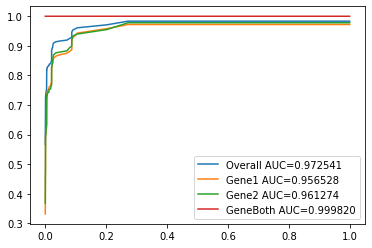

In [148]:
bfdpNullLarge, altCountsNullBfPermLarge = bayes.bfNullGenePosterior(alphas=tensor(testFitLarge["params"][0][3:]), pis=tensor(testFitLarge["params"][0][0:3]), nCases=paramsLarge["nCases"], nCtrls=paramsLarge["nCtrls"], af=paramsLarge["afMean"], pDs=paramsLarge["pDs"], nIterations=tensor([50_000]))
bfdpDataLarge = bayes.bfdp(altCounts=testDataLarge["altCounts"], pDs=paramsLarge["pDs"], alphas=tensor(testFitLarge["params"][0][3:]), pis=tensor(testFitLarge["params"][0][0:3]), )

bayes.genAucRocRiskGene(bfdpNullLarge, bfdpDataLarge, affectedGenes1=tensor(testDataLarge["affectedGenes"][0]), affectedGenes2=tensor(testDataLarge["affectedGenes"][1]), affectedGenesBoth=tensor(testDataLarge["affectedGenes"][2]))

In [156]:
h0, h1, h2, h3 = bayes.bfdpAlternates(altCounts=testDataLarge["altCounts"], pDs=paramsLarge["pDs"], alphas=tensor(testFitLarge["params"][0][3:]), pis=tensor(testFitLarge["params"][0][0:3]), nAlternateHypotheses=3)

print(testDataLarge["altCounts"])

print("h1/h0\n", (h1/h0)[0:100])
print("h1/h2\n", (h1/h2)[0:100])
print("h1/hBoth\n", (h1/h3)[0:100])

IN: altCountsFlat torch.Size([20000, 4])
pdCtrl, pd1, pd2, pdBoth:  tensor([0.9259, 0.0309, 0.0309, 0.0123], dtype=torch.float64)
effects tensor([[1.0077e-04, 1.9099e-07, 9.5404e-17],
        [6.4581e-04, 4.5037e-06, 1.6785e-15],
        [6.3969e-04, 4.7604e-08, 1.0784e-15],
        ...,
        [1.4948e-06, 1.9533e-04, 6.0068e-22],
        [1.8660e-05, 6.9730e-05, 5.8042e-18],
        [1.8178e-05, 8.6765e-05, 1.0126e-19]], dtype=torch.float64) 
effects[:, 0].shape:  torch.Size([20000])
denom tensor([0.0001, 0.0009, 0.0006,  ..., 0.0071, 0.0078, 0.0891],
       dtype=torch.float64) 
denom.shape: torch.Size([20000])
h0, h1, h2, h3
 tensor([2.0346e-04, 2.8480e-01, 2.1547e-03,  ..., 9.7238e-01, 9.8873e-01,
        9.9882e-01], dtype=torch.float64) 
 tensor([9.9791e-01, 7.1025e-01, 9.9777e-01,  ..., 2.0977e-04, 2.3802e-03,
        2.0400e-04], dtype=torch.float64) 
 tensor([1.8913e-03, 4.9531e-03, 7.4251e-05,  ..., 2.7411e-02, 8.8944e-03,
        9.7368e-04], dtype=torch.float64) 
 tensor(

In [301]:
testCounts

tensor([[30.,  2.,  1.,  1.],
        [26.,  4.,  0.,  1.],
        [31.,  3.,  0.,  0.],
        ...,
        [33.,  0.,  0.,  1.],
        [27.,  1.,  0.,  1.],
        [24.,  0.,  0.,  0.]], dtype=torch.float64)

In [120]:
testCountsLarge

tensor([[31.,  5.,  1.,  6.],
        [27.,  4.,  1.,  2.],
        [27.,  6.,  0.,  3.],
        ...,
        [35.,  0.,  3.,  1.],
        [30.,  2.,  3.,  0.],
        [28.,  0.,  1.,  0.]], dtype=torch.float64)

In [34]:
rrsMisspecified = tensor([10, 10, 10])

try:
    paramsMisspecified = genData.genParams(rrMeans=rrsMisspecified, pis=pis, afMean=afMean, rrShape=rrShape, afShape=afShape, nCases=nCases, nCtrls=nCtrls)[0]
    testDataMisspecified = generatingFn(**params, covShared=covShared, covSingle=covSingle)
except Exception as e:
    print(f"Run failed: {e}")

Run failed: name 'pis' is not defined


In [42]:
import torch
likelihoodFn, nullLike, likelihoodFnNoLatent = likelihoods.effectLikelihood(4, pDs=params["pDs"], altCountsFlat=testData["altCounts"])
pis = tensor(testFit["params"][0][0:3])
piNull = 1 - pis.sum()
alphas = testFit["params"][0][3:]
affectedGenes1 = tensor(testData["affectedGenes"][0])
affectedGenes2 = tensor(testData["affectedGenes"][1])
affectedGenesBoth = tensor(testData["affectedGenes"][2])

unaffectedGenes = testData["unaffectedGenes"]
alphas
mask1 = testData["altCounts"][:,1][affectedGenes1] > 0
affectedGenes1NonNull = torch.nonzero(mask1)
affectedGenes1NonNull.shape

like = likelihoodFn(*alphas)
like

likeWithNull = torch.stack([nullLike, like[:,0], like[:,1], like[:,2]]).T
likeWithNull

IN: altCountsFlat torch.Size([20000, 4])
pdCtrl, pd1, pd2, pdBoth:  tensor([0.9259, 0.0309, 0.0309, 0.0123], dtype=torch.float64)


NameError: name 'testFit' is not defined

In [32]:
likelihoodFnLarge, nullLikeLarge, likelihoodFnNoLatentLarge = likelihoods.effectLikelihood(4, pDs=paramsLarge["pDs"], altCountsFlat=testDataLarge["altCounts"])
pisLarge = tensor(testFitLarge["params"][0][0:3])
piNullLarge = 1 - pisLarge.sum()
alphasLarge = testFitLarge["params"][0][3:]
affectedGenes1Large = tensor(testDataLarge["affectedGenes"][0])
affectedGenes2Large = tensor(testDataLarge["affectedGenes"][1])
affectedGenesBothLarge = tensor(testDataLarge["affectedGenes"][2])

unaffectedGenesLarge = testDataLarge["unaffectedGenes"]
mask1Large = testDataLarge["altCounts"][:,1][affectedGenes1Large] > 0
affectedGenes1NonNullLarge = torch.nonzero(mask1Large)
affectedGenes1NonNullLarge.shape

likeLarge = likelihoodFnLarge(*alphasLarge)
likeLarge

likeLargeWithNull = torch.stack([nullLikeLarge, likeLarge[:,0], likeLarge[:,1], likeLarge[:,2]]).T
likeLargeWithNull

NameError: name 'paramsLarge' is not defined

In [ ]:
values, indices = torch.max(likeLargeWithNull[affectedGenes1Large],1)
maskLarge = indices != 1
badIndices = torch.nonzero(maskLarge)
print("n misclassified:", badIndices.shape, "out of", affectedGenes1Large.shape, "n genes", "is", len(badIndices)/len(affectedGenes1Large))

maskLargeAssumedNull = indices == 0
badIndicesAssumedNull = torch.nonzero(maskLargeAssumedNull)
print("n believed to be null:", badIndicesAssumedNull.shape, "out of", affectedGenes1Large.shape, "n genes", "is", len(badIndicesAssumedNull)/len(affectedGenes1Large))
badIndicesAssumedNull

In [ ]:
values, indices = torch.max(likeWithNull[affectedGenes1],1)
mask = indices != 1
badIndices = torch.nonzero(mask)
print("n misclassified:", badIndices.shape, "out of", affectedGenes1.shape, "genes", "; % correct: ", len(badIndices)/len(affectedGenes1))
badIndices

# maskAssumedNull = indices == 0
# badIndicesAssumedNull = torch.nonzero(maskAssumedNull)
# print("n believed to be null:", badIndicesAssumedNull.shape, "out of", affectedGenes1.shape, "n genes", "is", len(badIndicesAssumedNull)/len(affectedGenes1))
# badIndicesAssumedNull

In [ ]:
maskCount = testData["altCounts"][affectedGenes1, 1] != 0
torch.nonzero(maskCount)

In [381]:
badIdx = 903
print(testData["altCounts"][affectedGenes1][badIdx])
print(likeWithNull[badIdx])

tensor([31.,  0.,  0.,  0.], dtype=torch.float64)
tensor([9.2016e-02, 2.2061e-02, 1.9540e-02, 7.2670e-05], dtype=torch.float64)


In [351]:
print(likeLargeWithNull[102])
print(testDataLarge["altCounts"][102])

tensor([6.2325e-06, 1.4781e-04, 5.4868e-04, 1.7416e-10], dtype=torch.float64)
tensor([23.,  4.,  5.,  1.], dtype=torch.float64)


In [345]:
values, indices = torch.max(likeLargeWithNull[affectedGenesBothLarge],1)
maskLarge = indices != 3
badIndices = torch.nonzero(maskLarge)
print("n misclassified:", badIndices.shape, "out of", affectedGenesBothLarge.shape, "n genes", "is", len(badIndices)/len(affectedGenesBothLarge))
badIndices

n misclassified: torch.Size([2, 1]) out of torch.Size([798]) n genes is 0.002506265664160401


tensor([[287],
        [534]])

In [ ]:
values, indices = torch.max(likeLargeWithNull[affectedGenes2Large],1)
maskLarge = indices != 2
badIndices = torch.nonzero(maskLarge)
print("n misclassified:", badIndices.shape, "out of", affectedGenes2Large.shape, "n genes", "is", len(badIndices)/len(affectedGenes2Large))
badIndices


In [348]:
values, indices = torch.max(likeLargeWithNull[unaffectedGenesLarge],1)
maskLarge = indices != 0
badIndices = torch.nonzero(maskLarge)
print("n misclassified:", badIndices.shape, "out of", len(unaffectedGenesLarge), "n genes", "is", len(badIndices)/len(unaffectedGenesLarge))
badIndices


n misclassified: torch.Size([1375, 1]) out of 17280 n genes is 0.07957175925925926


tensor([[    3],
        [   16],
        [   18],
        ...,
        [17235],
        [17262],
        [17270]])

In [327]:
testDataLarge["altCounts"][982]

tensor([26.,  3.,  2.,  0.], dtype=torch.float64)

In [ ]:
nullLike[affectedGenes1NonNull]

In [ ]:
nullLike[affectedGenes1]

In [266]:
bayesFactorsAffected1 = like[unaffectedGenes].sum(1)/nullLike[unaffectedGenes]

In [274]:
d = bayesFactorsAffected1 < 1
print(torch.nonzero(d).shape)
print(len(unaffectedGenes))

torch.Size([6818, 1])
17000


In [99]:
bayesFactorsAffectedNull1 = like[testUnaffectedGenes,0]/nullLike[testUnaffectedGenes]

In [101]:
bayesFactorsAffectedNull1.min(0)

torch.return_types.min(
values=tensor(0.1546, dtype=torch.float64),
indices=tensor(4985))

In [42]:
testCountMisspecified = testDataMisspecified["altCounts"]

# bayesFactor(n, altCount,pDs,rrMeans,rrsShape,afMeans,afShape,alpha0, alpha1, alpha2, alphaBoth):
bfsAffected1 = []
for affectedGene in testAffectedGenes[0]:
    print(affectedGene, "count:", testCounts[affectedGene])
    testCount = testCountMisspecified[affectedGene]
    bfsAffected1.append(bayes.bayesFactor(testCountMisspecified.sum(), testCountMisspecified, testAllPDs, bestParams[0:3], bestParams[3:]))
bfsAffected1 = tensor(bfsAffected1)

0 count: tensor([34.,  0.,  3.,  0.], dtype=torch.float64)


TypeError: 'NoneType' object is not subscriptable

In [94]:
testData.keys()

dict_keys(['altCounts', 'afs', 'affectedGenes', 'unaffectedGenes', 'rrs'])

In [211]:
import torch
n = testCounts.sum(1).expand(3, len(testCounts)).T
alphas = tensor([1.77041095e+02,
       4.05096749e+02, 3.78310762e+02, 4.93211627e+02])
a0 = alphas[0]
a1 = alphas[1]
a2 = alphas[2]
a3 = alphas[3]
alphas2 = testAllPDs * tensor([[a0,a1,a0,a1], [a0,a0,a1,a1], [a0, a1+a3, a2+a3, a1+a2+a3]])
alphas2 = alphas2.expand(20_000, 3, 4)
print("testCounts.shape",testCounts.shape)
testCounts2 = testCounts.expand(3, 20_000, 4).transpose(0,1)
print("expanded", testCounts.expand(3, 20_000, 4).transpose(0,1).shape)
print(f"shapes: n {n.shape}, alphas: {alphas2.shape} counts: {testCounts2.shape}")

testCounts.shape torch.Size([20000, 4])
expanded torch.Size([20000, 3, 4])
shapes: n torch.Size([20000, 3]), alphas: torch.Size([20000, 3, 4]) counts: torch.Size([20000, 3, 4])


In [190]:
from pyro.distributions import DirichletMultinomial
#. this output is: nGenes by nHypotheses; 1 hypothesis per column
t = DirichletMultinomial(total_count = n, concentration=alphas2).log_prob(testCounts2)
t

shapes torch.Size([20000, 3, 1]) torch.Size([20000, 3, 4])
past


tensor([[ -4.6811,  -7.6378,  -7.5507],
        [ -9.4881, -13.3662,  -7.5881],
        [ -8.8253,  -7.5478,  -5.7675],
        ...,
        [ -3.8760,  -5.3455,  -9.6926],
        [ -5.9153,  -4.3251, -12.1820],
        [ -3.7168,  -5.1863,  -8.7299]], dtype=torch.float64)

In [196]:
t.sum(1).shape

torch.Size([20000])

In [194]:
t[0,2]

tensor(-7.5507, dtype=torch.float64)

In [114]:
# 4 genes, 3 hypothesis
nt = tensor([1,1,1,1]).expand(3,4).T
nt
n.expand(3, len(n)).T[]

tensor([34., 34., 34.], dtype=torch.float64)

In [176]:
r = DirichletMultinomial(total_count=tensor([3., 3, 3.]),concentration=tensor([[1.,2.,3,4],[1.,2,3,4],[1.,2,3,4]])).sample([20_000])

# total_count is hypotheses by 1 , concentration is hypotheses by sampleCategories, output is nGenes by hypotheses by sampleCategories
r.shape

print(r.shape)

# the sample shape is compatible with log_prob
DirichletMultinomial(total_count=tensor([3., 3, 3.]),concentration=tensor([[1.,2.,3,4],[1.,2,3,4],[1.,2,3,4]])).log_prob(r)


shapes torch.Size([3, 1]) torch.Size([3, 4])
past
torch.Size([20000, 3, 4])
shapes torch.Size([3, 1]) torch.Size([3, 4])
past


tensor([[-4.2950, -2.3979, -3.3142],
        [-3.1964, -3.0910, -3.0910],
        [-2.9087, -1.9924, -2.3979],
        ...,
        [-1.9924, -3.0910, -4.7005],
        [-3.1964, -2.2156, -1.9924],
        [-2.3979, -2.2156, -3.0910]])

In [479]:
import os
from os import path

folder = '/Users/alexkotlar/projects/tada/2020-05-251590382123'
r = np.load(path.join(folder, 'results_list.npy'), allow_pickle=True)

# print("done", r)

for i in range(len(r)):
    print(f"iteration {i}")
    params = r[i]
#     print("params", params)
    data = np.load(path.join(folder, i.__str__(), 'data.npy'), allow_pickle=True).item()
    runs = data["runs"]
    print(runs[0].keys())
#     print(runs[0]['altCounts'])
#     if 'error' in runs
    altCountsRun = runs[0]['results']["bestRes"]["pis"]
    print(altCountsRun)
#     break
    
    bestPis = []
    bestAlphas = []
    pdv1 = []
    pdv1True = []
    pdv2 = []
    pdvBoth = []
    pdNotv = []
#     altCounts = []
    i = 0
    for run in runs:
#         print(i)
        bestRes = run['results']["bestRes"]
        bestAlphas.append(bestRes['alphas'].numpy())
        print(run["altCounts"][0:1000])
        break
#         print(bestRes)
#         altCounts.append(run["altCounts"][0:1000].numpy())
        
        bestPis.append(bestRes["pis"].numpy())
        pdv1.append(bestRes["PDV_c1inferred"].numpy())
#         print(bestRes["PDV_c1inferred"].numpy())
#         print(bestRes["PDV_cBothTrue"].numpy(), bestRes["PDV_cBothInferred"].numpy())
        pdv1True.append(bestRes["PDV_c1true"].numpy())
        pdv2.append(bestRes["PDV_c2inferred"].numpy())
        pdvBoth.append(bestRes["PDV_cBothInferred"].numpy())
        i += 1
        
    bestPis = tensor(bestPis)
    pdv1 = tensor(pdv1)
    pdv1True = tensor(pdv1True)
    bestAlphas = tensor(bestAlphas)
    
    print("pis:", "mean:", bestPis.mean(0), "std:", bestPis.std(0))
    print('alphas:','median:', bestAlphas.mean(0))
    print("pdv1 inferred:", "mean:", pdv1.mean(0), "std:", pdv1.std(0))
    print("pdv1 true:", "mean:", pdv1True.mean(0), "std:", pdv1True.std(0))
#     print("altcount means", tensor(altCounts).mean(1))
    break

    

iteration 0
dict_keys(['altCounts', 'afs', 'affectedGenes', 'unaffectedGenes', 'generatingFn', 'results'])
tensor([0.0060, 0.0057, 0.0107], dtype=torch.float64)
tensor([[3., 0., 0., 0.],
        [3., 0., 0., 0.],
        [1., 2., 0., 0.],
        ...,
        [3., 0., 0., 0.],
        [2., 0., 0., 0.],
        [2., 0., 0., 0.]], dtype=torch.float64)
pis: mean: tensor(nan) std: tensor(nan)
alphas: median: tensor([  280.3403, 13455.0194, 15702.6012, 93028.1288], dtype=torch.float64)
pdv1 inferred: mean: tensor(nan) std: tensor(nan)
pdv1 true: mean: tensor(nan) std: tensor(nan)


In [75]:
rrsUpscale = tensor([1.5, 1.5, 1.25])
pisUpscale = tensor([.15, .02, .01])
nCasesUpscale = tensor([3500., 3500, 700])
nCtrlsUpscale = tensor(50_000.)
pDsUpscale = nCasesUpscale / (nCasesUpscale.sum() + nCtrlsUpscale)
print("pDsUpscale", pDsUpscale, nCasesUpscale.sum() + nCtrlsUpscale)
afMeanUpscale = tensor(1e-3)
rrShapeUpscale = tensor(50.)
afShapeUpscale = tensor(50.)
covSharedUpscale = tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]])
covSingleUpscale = tensor([[1, 0],
        [0, 1]])

generatingFn =  genData.v6normal
fitMethod = 'nelder-mead'
nEpochs=1
mt = True

try:
    paramsUpscale = genData.genParams(rrMeans=rrsUpscale, pis=pisUpscale, afMean=afMeanUpscale, rrShape=rrShapeUpscale, afShape=afShapeUpscale, nCases=nCasesUpscale, nCtrls=nCtrlsUpscale, pDs=pDsUpscale, covShared=covSharedUpscale, covSingle=covSingleUpscale)[0]
    testDataUpscale = generatingFn(approx=True, **paramsUpscale)
except Exception as e:
    print(f"Run failed: {e}")

pDsUpscale tensor([0.0607, 0.0607, 0.0121]) tensor(57700.)
pDs are: tensor([0.0607, 0.0607, 0.0121])
covShared is tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]])
TESTING WITH: nCases tensor([3500., 3500.,  700.]) nCtrls tensor(50000.) rrMeans tensor([1.5000, 1.5000, 1.2500]) afMean tensor(0.0010) afShape tensor(50.) diseaseFractions tensor([0.1500, 0.0200, 0.0100]) pDs tensor([0.0607, 0.0607, 0.0121]) covShared tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]]) covSingle tensor([[1, 0],
        [0, 1]])


test tensor 1,0,0,0,1,0,0,0,1
rrsShared tensor([[1.6013, 3.1376, 4.6150],
        [3.9195, 4.5082, 3.7365],
        [5.7590, 2.7815, 3.6646],
        ...,
        [2.3454, 2.5816, 4.6275],
        [1.7600, 3.1810, 3.3628],
        [4.0957, 2.2914, 4.6272]], dtype=torch.float64) means tensor([2.8323, 2.8482, 4.2463], dtype=torch.float64)
rrShared correlation 1 & 2 [[1.         0.00165906]
 [0.00165906 1.        ]]
rrShared correlation 1 & 3 [[1.         0.01477927]
 [0

In [ ]:
print("paramsUpscale", paramsUpscale)
testFitUpscale = likelihoods.fitFnBivariateMT(altCountsFlat=testDataUpscale["altCounts"],pDs=paramsUpscale["pDs"],nEpochs=1)

In [77]:
testFitUpscaleAllRes = testFitUpscale

In [78]:
testFitUpscaleAllRes

[{'lls': [108975.95699817828],
  'llsAll': [108975.95699817828],
  'params': [array([8.67271819e-02, 1.68909253e-02, 9.00218626e-03, 2.68602153e+02,
          7.75986048e+02, 6.96214168e+02, 5.06850629e+02])],
  'trajectoryLLs': [tensor(114462.1243, dtype=torch.float64),
   tensor(112895.3124, dtype=torch.float64),
   tensor(118200.5431, dtype=torch.float64),
   tensor(111999.6566, dtype=torch.float64),
   tensor(112707.3400, dtype=torch.float64),
   tensor(118926.4678, dtype=torch.float64),
   tensor(113105.2437, dtype=torch.float64),
   tensor(112503.5716, dtype=torch.float64),
   tensor(113730.5275, dtype=torch.float64),
   tensor(111386.9116, dtype=torch.float64),
   tensor(111216.4716, dtype=torch.float64),
   tensor(117215.6508, dtype=torch.float64),
   tensor(113772.9175, dtype=torch.float64),
   tensor(121430.0307, dtype=torch.float64),
   tensor(112420.6825, dtype=torch.float64),
   tensor(122253.2639, dtype=torch.float64),
   tensor(113817.2666, dtype=torch.float64),
   tenso

In [79]:
testFitUpscaleAllRes[0]["lls"]

[108975.95699817828]

In [80]:
testFitUpscaleAllRes[0]["params"]

[array([8.67271819e-02, 1.68909253e-02, 9.00218626e-03, 2.68602153e+02,
        7.75986048e+02, 6.96214168e+02, 5.06850629e+02])]

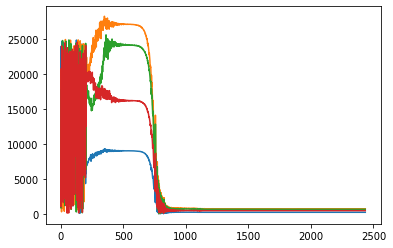

In [81]:
pyplot.plot(tensor(testFitUpscaleAllRes[0]["trajectoryAlphas"]))

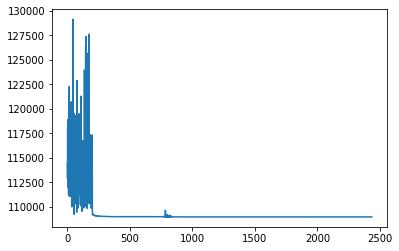

In [82]:
pyplot.plot(tensor(testFitUpscaleAllRes[0]["trajectoryLLs"]))

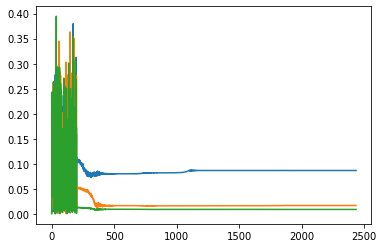

In [83]:
pyplot.plot(tensor(testFitUpscaleAllRes[0]["trajectoryPi"]))

In [84]:
bestLLUpscale = None
bestResIdx = -1
i = 0
for res in testFitUpscale:
    assert(len(res["lls"]) == 1)
    if bestLLUpscale is None or res["lls"][0] < bestLLUpscale:
        bestLLUpscale = res["lls"][0]
        bestResIdx = i
    i += 1
        
testFitUpscale = testFitUpscale[bestResIdx]


In [85]:
print('pis', testFitUpscale["params"][0][:3], 'alphas', testFitUpscale["params"][0][3:])

pis [0.08672718 0.01689093 0.00900219] alphas [268.6021532  775.986048   696.21416849 506.85062858]


In [86]:
pdgivenVestimate = likelihoods.inferPDGivenVfromAlphas(tensor(testFitUpscale["params"][0][3:]), pds=pDsUpscale)
pdgivenVestimate

(tensor([0.7644, 0.1545, 0.0535, 0.0276], dtype=torch.float64),
 tensor([0.7765, 0.0544, 0.1410, 0.0281], dtype=torch.float64),
 tensor([0.5708, 0.1909, 0.1793, 0.0590], dtype=torch.float64))

In [87]:
truePDGivenV = likelihoods.empiricalPDGivenV(testDataUpscale["afs"], affectedGenes=testDataUpscale["affectedGenes"],truePV=afMeanUpscale)
truePDGivenV

(tensor([0.7936, 0.1222, 0.0607, 0.0244], dtype=torch.float64),
 tensor([0.7959, 0.0607, 0.1199, 0.0240], dtype=torch.float64),
 tensor([0.6143, 0.1774, 0.1709, 0.0522], dtype=torch.float64))

In [127]:
# from pyro.distributions import Dirichlet
# upscalePisInferred = tensor(testFitUpscale["params"][0][0:3])
# upscaleAlphasInferred = tensor(testFitUpscale["params"][0][3:])
# print("upscalePis", upscalePisInferred, "upscaleAlphas", upscaleAlphasInferred)

In [128]:
# A way to explore power

# # piNullUpscale = 1 - upscalePis.sum()

# likelihoodFnUpscale, nullLikeUpscale, likelihoodFnNoLatentUpscale = likelihoods.effectLikelihood(4, pDs=pDsUpscale, altCountsFlat=testDataUpscale["altCounts"])

# print("null", nullLikeUpscale * (1-upscalePisInferred.sum()))
# affectedGenes1Upscale = tensor(testDataUpscale["affectedGenes"][0])
# affectedGenes2Upscale = tensor(testDataUpscale["affectedGenes"][1])
# affectedGenesBothUpscale = tensor(testDataUpscale["affectedGenes"][2])
# unaffectedGenesUpscale = testDataUpscale["unaffectedGenes"]

# # print(nullLikeUpscale)
# posteriorExpectationEffect = upscalePisInferred * likelihoodFnUpscale(*upscaleAlphasInferred)
# posteriorExpectationNull = (1-upscalePisInferred.sum()) * nullLikeUpscale

# # print("posteriorExpectationOverPDV", posteriorExpectationOverPDV)
# # print("posteriorExpectationOverPD", posteriorExpectationNull)

# likeUpscaleWithNull = torch.stack([posteriorExpectationNull, posteriorExpectationEffect[:,0], posteriorExpectationEffect[:,1], posteriorExpectationEffect[:,2]]).T
# print("likeUpscaleWithNull", likeUpscaleWithNull[0:100])
# print(testDataUpscale["altCounts"][0:100])

# valuesUpscale, indicesUpscale = torch.max(likeUpscaleWithNull[affectedGenes1Upscale],1)
# maskUpscale = indicesUpscale != 1
# badIndicesUpscale = torch.nonzero(maskUpscale)
# maskGoodUpscale = indicesUpscale == 1
# goodIndicesUpscale = torch.nonzero(maskGoodUpscale)
# # print("n misclassified:", badIndicesUpscale.shape, "out of", affectedGenes1Upscale.shape, "n genes", "fraction bad: ", len(badIndicesUpscale)/len(affectedGenes1Upscale))
# print("%Correctly classfieid genes affecting 1:", len(goodIndicesUpscale) * 100/len(affectedGenes1Upscale))

# numRight1orBoth = 0
# for idx in indicesUpscale:
#     if idx == 1 or idx == 3:
#         numRight1orBoth += 1
        
# # goodIndicesUpscaleAssumedNull = torch.nonzero(maskUpsacelAssumedNull)
# print("%Correct classfieid genes affecting 1 if we call correct H1 or HBoth:", numRight1orBoth * 100/len(affectedGenes1Upscale))
# # maskUpscale

# numRightAnyAlternateHypothesis = 0
# for idx in indicesUpscale:
#     if idx != 0:
#         numRightAnyAlternateHypothesis += 1
        
# # goodIndicesUpscaleAssumedNull = torch.nonzero(maskUpsacelAssumedNull)
# print("%Correct classfieid genes affecting 1 if we call correct non-H0 (likelihood max):", numRightAnyAlternateHypothesis * 100/len(affectedGenes1Upscale))
# # maskUpscale

# valuesUpscale, indicesUpscale = torch.max(likeUpscaleWithNull[affectedGenes2Upscale],1)
# maskUpscale = indicesUpscale != 2
# badIndicesUpscale = torch.nonzero(maskUpscale)
# maskGoodUpscale = indicesUpscale == 2
# goodIndicesUpscale = torch.nonzero(maskGoodUpscale)
# # print("n misclassified:", badIndicesUpscale.shape, "out of", affectedGenes1Upscale.shape, "n genes", "fraction bad: ", len(badIndicesUpscale)/len(affectedGenes1Upscale))
# print("%Correctly classfieid risk genes 2:", len(goodIndicesUpscale) * 100/len(affectedGenes2Upscale))
# maskArgmaxUpscale = indicesUpscale != 0
# goodIndicesUpscale = torch.nonzero(maskArgmaxUpscale)
# # print("n misclassified:", badIndicesUpscale.shape, "out of", affectedGenes1Upscale.shape, "n genes", "fraction bad: ", len(badIndicesUpscale)/len(affectedGenes1Upscale))
# print("%Correctly classfieid risk genes 2 using argmax:", len(goodIndicesUpscale) * 100/len(affectedGenes2Upscale))


In [88]:
testDataUpscale["altCounts"]

tensor([[54.,  1.,  5.,  0.],
        [46.,  5.,  4.,  2.],
        [43., 11.,  3.,  2.],
        ...,
        [52.,  8.,  1.,  0.],
        [56.,  3.,  5.,  2.],
        [49.,  7.,  5.,  2.]], dtype=torch.float64)

{'nGenes': 20000, 'nCases': tensor([3500., 3500.,  700.]), 'nCtrls': tensor(50000.), 'pDs': tensor([0.0607, 0.0607, 0.0121]), 'diseaseFractions': tensor([0.1500, 0.0200, 0.0100]), 'rrShape': tensor(50.), 'rrMeans': tensor([1.5000, 1.5000, 1.2500]), 'afShape': tensor(50.), 'afMean': tensor(0.0010), 'covShared': tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]]), 'covSingle': tensor([[1, 0],
        [0, 1]])}
getAlphas(testFitUpscale): tensor([268.6022, 775.9860, 696.2142, 506.8506], dtype=torch.float64)
testDataUpscale['altCounts']: tensor([[54.,  1.,  5.,  0.],
        [46.,  5.,  4.,  2.],
        [43., 11.,  3.,  2.],
        ...,
        [52.,  8.,  1.,  0.],
        [56.,  3.,  5.,  2.],
        [49.,  7.,  5.,  2.]], dtype=torch.float64)
Params: tensor([268.6022, 775.9860, 696.2142, 506.8506], dtype=torch.float64) tensor([0.0867, 0.0169, 0.0090], dtype=torch.float64) tensor([3500., 3500.,  700.]) tensor(50000.) tensor(0.0010) tensor([0.0607, 0.0607, 0.0121]) tensor([50000])

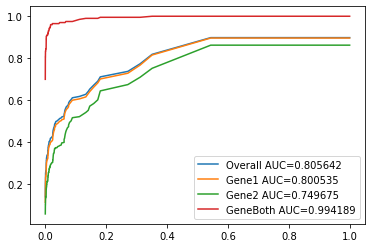

In [89]:
print(paramsUpscale)
print(f"getAlphas(testFitUpscale): {getAlphas(testFitUpscale)}")
print(f"testDataUpscale['altCounts']: {testDataUpscale['altCounts']}")
bfdpNull, altCountsNullBfPerm = bayes.bfNullGenePosterior(getAlphas(testFitUpscale), getPis(testFitUpscale), nIterations=tensor([50_000]), **paramsUpscale)
bfdpData = bayes.bfdp(altCounts=testDataUpscale["altCounts"], pDs=paramsUpscale["pDs"], alphas=tensor(testFitUpscale["params"][0][3:]), pis=tensor(testFitUpscale["params"][0][0:3]), )

bayes.genAucRocRiskGene(bfdpNull, bfdpData, affectedGenes1=tensor(testDataUpscale["affectedGenes"][0]), affectedGenes2=tensor(testDataUpscale["affectedGenes"][1]), affectedGenesBoth=tensor(testDataUpscale["affectedGenes"][2]), name="test-full-posterior.png")

Params: tensor([268.6022, 775.9860, 696.2142, 506.8506], dtype=torch.float64) tensor([0.1500, 0.0200, 0.0100]) tensor([3500., 3500.,  700.]) tensor(50000.) tensor(0.0010) tensor([0.0607, 0.0607, 0.0121]) tensor([50000])
Added specificity 0
real vs null genes1
tensor([45.3527,  6.9787,  3.5253,  1.3977], dtype=torch.float64)
tensor([49.4120,  3.4543,  3.4490,  0.6847])
real vs null genes2
tensor([45.4225,  3.3750,  7.0450,  1.4000], dtype=torch.float64)
tensor([49.4225,  3.3325,  3.5350,  0.7100])
real vs null genes2
tensor([34.9200, 10.0900,  9.8400,  3.1900], dtype=torch.float64)
tensor([49.3450,  3.4250,  3.4250,  0.8050])
3


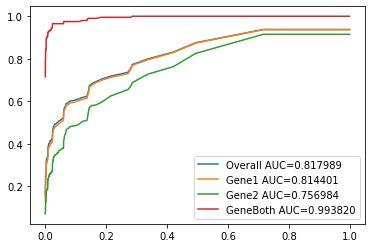

In [90]:
# with the exact right pis
bfdpNull, altCountsNullBfPerm = bayes.bfNullGenePosterior(getAlphas(testFitUpscale), paramsUpscale["diseaseFractions"], nIterations=tensor([50_000]), **paramsUpscale)
bfdpData = bayes.bfdp(altCounts=testDataUpscale["altCounts"], pDs=paramsUpscale["pDs"], alphas=getAlphas(testFitUpscale), pis=paramsUpscale["diseaseFractions"], )

bayes.genAucRocRiskGene(bfdpNull, bfdpData, affectedGenes1=tensor(testDataUpscale["affectedGenes"][0]), affectedGenes2=tensor(testDataUpscale["affectedGenes"][1]), affectedGenesBoth=tensor(testDataUpscale["affectedGenes"][2]), name='test-full-posterior-with-exact-prior.png')
print("real vs null genes1")
print(testDataUpscale["altCounts"][testDataUpscale["affectedGenes"][0]].mean(0))
print(altCountsNullBfPerm[testDataUpscale["affectedGenes"][0]].mean(0))
print("real vs null genes2")
print(testDataUpscale["altCounts"][testDataUpscale["affectedGenes"][1]].mean(0))
print(altCountsNullBfPerm[testDataUpscale["affectedGenes"][1]].mean(0))
print("real vs null genes2")
print(testDataUpscale["altCounts"][testDataUpscale["affectedGenes"][2]].mean(0))
print(altCountsNullBfPerm[testDataUpscale["affectedGenes"][2]].mean(0))
print(len(testDataUpscale["affectedGenes"]))




Params: tensor([268.6022, 775.9860, 696.2142, 506.8506], dtype=torch.float64) tensor([0.2500, 0.2500, 0.2500]) tensor([3500., 3500.,  700.]) tensor(50000.) tensor(0.0010) tensor([0.0607, 0.0607, 0.0121]) tensor([50000])


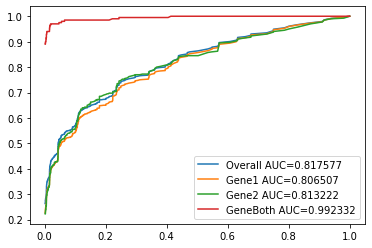

In [94]:
bfdpNullFlat, altCountsNullBfPermFlat = bayes.bfNullGenePosteriorFlatPrior(alphas=getAlphas(testFitUpscale),
                                                                           nIterations=tensor([50_000]),
                                                                           **paramsUpscale)
bfdpDataFlat = bayes.bfdpFlatPrior(altCounts=testDataUpscale["altCounts"], pDs=paramsUpscale["pDs"],
                                   alphas=tensor(testFitUpscale["params"][0][3:]))

bayes.genAucRocRiskGene(bfdpNullFlat, bfdpDataFlat, affectedGenes1=tensor(testDataUpscale["affectedGenes"][0]), affectedGenes2=tensor(testDataUpscale["affectedGenes"][1]), affectedGenesBoth=tensor(testDataUpscale["affectedGenes"][2]), name='test-flat-prior.png')

In [194]:
bfdpDataH1 = bayes.bfdpOneAltHypothesis(altCounts=testDataUpscale["altCounts"], pDs=paramsUpscale["pDs"], alphas=tensor(testFitUpscale["params"][0][3:]), pis=paramsUpscale["diseaseFractions"], )
bfdpDataH1Threshold = bfdpThreshold2

In [185]:
paramsUpscale

{'nGenes': 20000,
 'nCases': tensor([10000., 10000.,  4000.]),
 'nCtrls': tensor(300000.),
 'pDs': tensor([0.0100, 0.0100, 0.0020]),
 'diseaseFractions': tensor([0.1000, 0.0100, 0.0100]),
 'rrShape': tensor(50.),
 'rrMeans': tensor([5, 5, 2]),
 'afShape': tensor(50.),
 'afMean': tensor(1.0000e-04),
 'covShared': tensor([[1, 0, 0],
         [0, 1, 0],
         [0, 0, 1]]),
 'covSingle': tensor([[1, 0],
         [0, 1]])}

In [271]:
nullCountsUpscale, nullPupscale = bayes.genNullData(getAlphas(testFitUpscale), getPis(testFitUpscale), nIterations=tensor([20_000]), **paramsUpscale)
print(nullCountsUpscale.size())
print(nullPupscale)

Params: tensor([13953.1617, 77834.3856, 75596.0236, 41751.0756], dtype=torch.float64) tensor([0.0899, 0.0134, 0.0086], dtype=torch.float64) tensor([10000., 10000.,  4000.]) tensor(300000.) tensor(1.0000e-04) tensor([0.0100, 0.0100, 0.0020]) tensor([20000])
torch.Size([20000, 4])
tensor([9.7800e-05, 1.0000e-06, 1.0000e-06, 2.0000e-07])


In [259]:
paramsUpscale

{'nGenes': 20000,
 'nCases': tensor([10000., 10000.,  4000.]),
 'nCtrls': tensor(300000.),
 'pDs': tensor([0.0100, 0.0100, 0.0020]),
 'diseaseFractions': tensor([0.1000, 0.0100, 0.0100]),
 'rrShape': tensor(50.),
 'rrMeans': tensor([5, 5, 2]),
 'afShape': tensor(50.),
 'afMean': tensor(1.0000e-04),
 'covShared': tensor([[1, 0, 0],
         [0, 1, 0],
         [0, 0, 1]]),
 'covSingle': tensor([[1, 0],
         [0, 1]])}

In [272]:
bfdpAltH1NullUpscale = bayes.bfdpOneAltHypothesis(altCounts=nullCountsUpscale, pDs=paramsUpscale["pDs"], alphas=getAlphas(testFitUpscale), pis=getPis(testFitUpscale), hIdx=0)
bfdpAlt1H1UpscaleNeeded, fdrH1upscale = bayes.bfdpThreshold2(bfdpAltH1NullUpscale, getAlphas(testFitUpscale), getPis(testFitUpscale), targetFDR=.1, nIterations=tensor([50_000]), **paramsUpscale)
print(bfdpAlt1H1UpscaleNeeded)
print(fdrH1upscale)


altCounts torch.Size([20000, 4])
effectLikes torch.Size([20000, 3])
empirical fdr 56.54446 0.02735
0.017685198514584805
0.02735


In [267]:
likelihoodFn, nullLikes, likelihoodFnSimpleNoLatent = bayes.effectLikelihood(4, pDs=paramsUpscale["pDs"], altCountsFlat=testDataUpscale["altCounts"])
effectLikesUpscale = likelihoodFn(*getAlphas(testFitUpscale))
print("right model", effectLikesUpscale[testDataUpscale["affectedGenes"][2]][0:10])
effectLikesSimpleUpscale = likelihoodFnSimpleNoLatent(*getAlphas(testFitUpscale))
print("simple model", effectLikesSimpleUpscale[testDataUpscale["affectedGenes"][2]][0:10])

bfdpAltH1NullUpscale = bayes.bfdpOneAltHypothesis(altCounts=testDataUpscale["altCounts"], pDs=paramsUpscale["pDs"], alphas=getAlphas(testFitUpscale), pis=getPis(testFitUpscale), hIdx=0)
print("len", len(bfdpAltH1NullUpscale))
bfdpAltH2NullUpscale = bayes.bfdpOneAltHypothesis(altCounts=testDataUpscale["altCounts"], pDs=paramsUpscale["pDs"], alphas=getAlphas(testFitUpscale), pis=getPis(testFitUpscale), hIdx=1)
bfdpAltHBothNullUpscale = bayes.bfdpOneAltHypothesis(altCounts=testDataUpscale["altCounts"], pDs=paramsUpscale["pDs"], alphas=getAlphas(testFitUpscale), pis=getPis(testFitUpscale), hIdx=2)

countCorrect = 0
for i in testDataUpscale["affectedGenes"][0]:
    if bfdpAltH1NullUpscale[i] > bfdpAltH2NullUpscale[i] and bfdpAltH1NullUpscale[i] > bfdpAltHBothNullUpscale[i] and bfdpAltH1NullUpscale[i] > bfdpAlt1H1UpscaleNeeded:
#         print("good")
        countCorrect += 1
        
print(countCorrect)
print(countCorrect / len(testDataUpscale["affectedGenes"][0]))

countIncorrect = 0
for i in testDataUpscale["affectedGenes"][1]:
    if bfdpAltH1NullUpscale[i] > bfdpAltH2NullUpscale[i] and bfdpAltH1NullUpscale[i] > bfdpAltHBothNullUpscale[i] and bfdpAltH1NullUpscale[i] > bfdpAlt1H1UpscaleNeeded:
#         print("good")
        countIncorrect += 1
    
for i in testDataUpscale["affectedGenes"][2]:
    if bfdpAltH1NullUpscale[i] > bfdpAltH2NullUpscale[i] and bfdpAltH1NullUpscale[i] > bfdpAltHBothNullUpscale[i] and bfdpAltH1NullUpscale[i] > bfdpAlt1H1UpscaleNeeded:
#         print("good")
        countIncorrect += 1
    
for i in testDataUpscale["unaffectedGenes"]:
    if bfdpAltH1NullUpscale[i] > bfdpAltH2NullUpscale[i] and bfdpAltH1NullUpscale[i] > bfdpAltHBothNullUpscale[i] and bfdpAltH1NullUpscale[i] > bfdpAlt1H1UpscaleNeeded:
#         print("good")
        countIncorrect += 1
        
print(countCorrect)
print(countCorrect / len(testDataUpscale["affectedGenes"][0]))

print("nIncorrect", countIncorrect, "out of", len(testDataUpscale["affectedGenes"][1]) + len(testDataUpscale["affectedGenes"][2]) + len(testDataUpscale["unaffectedGenes"]))
print(len(testDataUpscale["unaffectedGenes"]))

right model tensor([[9.6544e-03, 5.9305e-05, 1.4083e-02],
        [8.0450e-03, 4.4699e-02, 2.4334e-02],
        [8.6072e-06, 2.3542e-04, 7.2251e-03],
        [4.4662e-04, 2.3573e-03, 2.0260e-02],
        [2.6136e-06, 4.4426e-07, 4.3888e-03],
        [3.1501e-03, 1.7092e-02, 1.7270e-02],
        [5.6295e-04, 1.6569e-02, 2.7076e-02],
        [1.4752e-01, 5.0004e-03, 2.0800e-02],
        [1.1581e-02, 1.1372e-02, 3.4582e-02],
        [2.4907e-06, 2.0781e-03, 5.8623e-03]], dtype=torch.float64)
simple model tensor([[9.6544e-03, 5.9305e-05, 1.0299e-02],
        [8.0450e-03, 4.4699e-02, 4.3941e-02],
        [8.6072e-06, 2.3542e-04, 3.4612e-03],
        [4.4662e-04, 2.3573e-03, 1.8057e-02],
        [2.6136e-06, 4.4426e-07, 6.2273e-04],
        [3.1501e-03, 1.7092e-02, 2.9129e-02],
        [5.6295e-04, 1.6569e-02, 2.2326e-02],
        [1.4752e-01, 5.0004e-03, 3.9384e-02],
        [1.1581e-02, 1.1372e-02, 4.0454e-02],
        [2.4907e-06, 2.0781e-03, 2.3918e-03]], dtype=torch.float64)
altCounts t

In [229]:
from pyro.distributions import Gamma
# TADA parameters
# for gamma != 1, Gamma(.5, 10_000), for gamma 1, q ~ Gamma(.5, 500)
Gamma(.5,500).sample([10_000]).mean()

tensor(0.0010)

In [137]:
bfdpNeededH0vsHA, fdr = bayes.bfdpThreshold(alphas=tensor(testFitUpscale["params"][0][3:]), pis=tensor(testFitUpscale["params"][0][:3]),
                    nCases=paramsUpscale["nCases"], nCtrls=paramsUpscale["nCtrls"],
                    afMean=paramsUpscale["afMean"], pDs=paramsUpscale["pDs"],
                    targetFDR=.1)

empirical p 1.12142 0.07936


In [146]:
bfdpNeededH0vsHA

0.8917265609673449

In [138]:
bfdpNeededH0vsHAFlatPrior, fdrFlatPrior = bayes.bfdpThresholdFlatPrior(alphas=tensor(testFitUpscale["params"][0][3:]),
                    nCases=paramsUpscale["nCases"], nCtrls=paramsUpscale["nCtrls"],
                    afMean=paramsUpscale["afMean"], pDs=paramsUpscale["pDs"],
                    targetFDR=.1)

empirical p 7.19702 0.07908


In [141]:
bfdpNeededH0vsHAFlatPrior

0.13894639725886548

In [168]:
#h1 = P(H1|x) = P(X|H1)P(H1) / sum(P(X|H0..3)*P(H0...3))
#h0 = P(H0|x)
# h1/h0 = P(X|H1)P(H1)  / P(X|H0)P(H0)
print(tensor(testDataUpscale["affectedGenes"][0]).min(), tensor(testDataUpscale["affectedGenes"][0]).max())
h0, h1, h2, h3 = bayes.bfdpAlternates(altCounts=testDataUpscale["altCounts"], pDs=paramsUpscale["pDs"],
                                      alphas=tensor(testFitUpscale["params"][0][3:]), pis=tensor(testFitUpscale["params"][0][:3]), nAlternateHypotheses=3)
# print("testing", h0[1000:1200],h1[1000:1200],h2[1000:1200])
print(torch.nonzero(testDataUpscale["altCounts"][0:1000, 1] > 0).size())
print(torch.nonzero((h0[0:2000] >= bfdpNeededH0vsHA)).size())
print(torch.nonzero((h1[0:2000] >= bfdpNeededH0vsHA)).size())
print(torch.nonzero(((h1[0:2000]/h0[0:2000]) >= 1/bfdpNeededH0vsHA)).size())
print(torch.nonzero(((h1[4000:]/h0[4000:]) >= 1/bfdpNeededH0vsHA)).size())
print(torch.nonzero(((h2[2000:4000]/h0[2000:4000]) >= 1/bfdpNeededH0vsHA)).size())
print(torch.nonzero(((h2[4000:]/h0[4000:]) >= 1/bfdpNeededH0vsHA)).size())
print(torch.nonzero(((h0[4000:]) >= bfdpNeededH0vsHA)).size())

nCorrect = 0
for i in testDataUpscale["affectedGenes"][0]:
    if h1[i] > h0[i] and h1[i] > h2[i] and h1[i] > h3[i]:
        nCorrect += 1
    
print("% correct for genes 1: ", nCorrect/len(testDataUpscale["affectedGenes"][0]))

nCorrect2 = 0
for i in testDataUpscale["affectedGenes"][1]:
    if h2[i] > h0[i] and h2[i] > h1[i] and h2[i] > h3[i]:
        nCorrect2 += 1
    
print("% correct for genes 2: ", nCorrect2/len(testDataUpscale["affectedGenes"][1]))

nCorrect3 = 0
for i in testDataUpscale["affectedGenes"][2]:
    if h3[i] > h0[i] and h3[i] > h2[i] and h3[i] > h1[i]:
        nCorrect3 += 1
    
print("% correct for genes 3: ", nCorrect3/len(testDataUpscale["affectedGenes"][2]))

tensor(0) tensor(1999)
effects tensor([[1.7922e-02, 5.0395e-04, 1.4126e-04],
        [1.3913e-02, 3.9553e-04, 5.7278e-05],
        [1.8007e-03, 1.6851e-06, 7.6438e-05],
        ...,
        [7.4092e-03, 1.1750e-03, 1.9853e-05],
        [1.0811e-02, 1.6989e-03, 4.9769e-05],
        [8.6179e-03, 1.3617e-03, 2.8672e-05]], dtype=torch.float64) 
effects[:, 0].shape:  torch.Size([20000])
denom tensor([0.1530, 0.1582, 0.0021,  ..., 0.4348, 0.4889, 0.4556],
       dtype=torch.float64) 
denom.shape: torch.Size([20000])
h0, h1, h2, h3
 tensor([0.8787, 0.9092, 0.0890,  ..., 0.9802, 0.9743, 0.9780],
       dtype=torch.float64) 
 tensor([0.1171, 0.0880, 0.8731,  ..., 0.0170, 0.0221, 0.0189],
       dtype=torch.float64) 
 tensor([0.0033, 0.0025, 0.0008,  ..., 0.0027, 0.0035, 0.0030],
       dtype=torch.float64) 
 tensor([9.2305e-04, 3.6211e-04, 3.7062e-02,  ..., 4.5659e-05, 1.0180e-04,
        6.2932e-05], dtype=torch.float64)
effects[:, 0] / null tensor([0.1333, 0.0967, 9.8113,  ..., 0.0174, 0.0227

In [169]:
h0, h1, h2, h3 = bayes.bfdpAlternatesFlatPrior(altCounts=testDataUpscale["altCounts"], pDs=paramsUpscale["pDs"], alphas=tensor(testFitUpscale["params"][0][3:]), nAlternateHypotheses=3)

print(torch.nonzero(testDataUpscale["altCounts"][0:1000, 1] > 0).size())
print(torch.nonzero((h0[0:2000] >= bfdpNeededH0vsHAFlatPrior)).size())
print(torch.nonzero((h1[0:2000] >= bfdpNeededH0vsHAFlatPrior)).size())
print(torch.nonzero((h0[1000:2000] >= bfdpNeededH0vsHAFlatPrior)).size())
print(torch.nonzero(((h1[0:1000]/h0[0:1000]) >= 1/bfdpNeededH0vsHAFlatPrior)).size())
print(torch.nonzero(((h1[4000:]/h0[4000:]) >= 1/bfdpNeededH0vsHAFlatPrior)).size())
print(torch.nonzero(((h1[4000:]/h0[4000:]) >= 1/bfdpNeededH0vsHAFlatPrior)).size())
print(torch.nonzero(((h2[1000:2000]/h0[1000:2000]) >= 1/bfdpNeededH0vsHAFlatPrior)).size())
print(torch.nonzero(((h2[4000:]/h0[4000:]) >= 1/bfdpNeededH0vsHAFlatPrior)).size())
print(torch.nonzero(((h0[4000:]) >= bfdpNeededH0vsHAFlatPrior)).size())

nCorrect = 0
for i in testDataUpscale["affectedGenes"][0]:
    if h1[i] > h0[i] and h1[i] > h2[i] and h1[i] > h3[i]:
        nCorrect += 1
    
print("% correct for genes 1: ", nCorrect/len(testDataUpscale["affectedGenes"][0]))

nCorrect2 = 0
for i in testDataUpscale["affectedGenes"][1]:
    if h2[i] > h0[i] and h2[i] > h1[i] and h2[i] > h3[i]:
        nCorrect2 += 1
    
print("% correct for genes 2: ", nCorrect2/len(testDataUpscale["affectedGenes"][1]))

nCorrect3 = 0
for i in testDataUpscale["affectedGenes"][2]:
    if h3[i] > h0[i] and h3[i] > h2[i] and h3[i] > h1[i]:
        nCorrect3 += 1
    
print("% correct for genes 3: ", nCorrect3/len(testDataUpscale["affectedGenes"][2]))

effects tensor([[4.9826e-02, 9.3834e-03, 4.1053e-03],
        [3.8681e-02, 7.3646e-03, 1.6646e-03],
        [5.0064e-03, 3.1376e-05, 2.2215e-03],
        ...,
        [2.0599e-02, 2.1877e-02, 5.7697e-04],
        [3.0056e-02, 3.1632e-02, 1.4464e-03],
        [2.3959e-02, 2.5353e-02, 8.3329e-04]], dtype=torch.float64) 
effects[:, 0].shape:  torch.Size([20000])
denom tensor([0.1012, 0.0882, 0.0073,  ..., 0.1630, 0.1972, 0.1756],
       dtype=torch.float64) 
denom.shape: torch.Size([20000])
h0, h1, h2, h3
 tensor([0.3742, 0.4590, 0.0071,  ..., 0.7359, 0.6799, 0.7144],
       dtype=torch.float64) 
 tensor([0.4925, 0.4386, 0.6848,  ..., 0.1263, 0.1524, 0.1365],
       dtype=torch.float64) 
 tensor([0.0927, 0.0835, 0.0043,  ..., 0.1342, 0.1604, 0.1444],
       dtype=torch.float64) 
 tensor([0.0406, 0.0189, 0.3039,  ..., 0.0035, 0.0073, 0.0047],
       dtype=torch.float64)
effects[:, 0] / null tensor([ 1.3163,  0.9554, 96.8936,  ...,  0.1717,  0.2241,  0.1910],
       dtype=torch.float64)
tor

In [112]:
# upscaleFDRs = bayes.bayesFDRs(bfsUpscaled, upscalePis)
# fdr1 = upscaleFDRs[0]
# maxIdx = torch.nonzero(fdr1 <= .1)[-1]
# minFDR1 = bfsUpscaled[:,0][maxIdx]
# print("min BF at FDR <= .1 for genes1 is", minFDR1)
# minFDR2 = bfsUpscaled[:,1][maxIdx]
# print("min BF at FDR <= .1 for genes2 is", minFDR2)
# upscaleAffected1 = testDataUpscale["affectedGenes"][0]

# upscaleAffected2 = testDataUpscale["affectedGenes"][1]
# upscaleAffectedBoth = testDataUpscale["affectedGenes"][2]

# upscaleUnaffected = testDataUpscale["unaffectedGenes"]

# print(len(upscaleAffected1))
# print("power 1", len(torch.nonzero(bfsUpscaled[upscaleAffected1,0] >= minFDR1)) / len(upscaleAffected1))

# bfs1 = bfsUpscaled[upscaleAffected1]
# bfs2 = bfsUpscaled[upscaleAffected2]
# bfsBoth = bfsUpscaled[upscaleAffectedBoth]

# print("correctly id'd genes 1 compared to 2:", len(torch.nonzero(bfs1[:,0] >= bfs1[:,1])))
# print("correctly id'd genes 1 compared to Both:", len(torch.nonzero(bfs1[:,0] >= bfs1[:,2])))
# print("correctly id'd genes 2 compared to 1:", len(torch.nonzero(bfs2[:,1] >= bfs2[:,0])))
# print("correctly id'd genes 2 compared to Both:", len(torch.nonzero(bfs2[:,1] >= bfs2[:,2])))
# print("correctly id'd genes Both using comparison to component 2:", len(torch.nonzero(bfsBoth[:,2] >= bfsBoth[:,1])))
# print("correctly id'd  genes Both using comparison to component 1:", len(torch.nonzero(bfsBoth[:,2] >= bfsBoth[:,0])))


# bfThreshold = 4
# print(upscaleUnaffected[0])
# falseDiscoveries = torch.nonzero(bfsUpscaled[upscaleUnaffected[1:]].max(1).values > bfThreshold)
# print(bfsUpscaled[upscaleUnaffected[1:]].max(1).values.numpy())
# print(f"false discovery % at threshold {bfThreshold}:", len(falseDiscoveries) * 100 / len(upscaleUnaffected), "%")
# print("correctly id'd genes 1 using fdr threshold and argmax criteria:", len(torch.nonzero(bfs1.max(1).values >= 4)))
# print("correctly id'd genes 1 using fdr threshold:", len(torch.nonzero(bfs1[:, 0] >= 4)))
# print(bfs1[:].max(0))

In [ ]:
# print(bfsUpscaled)
# upscaleFDRs = bayes.bayesFDRsHA(bfsUpscaled, upscalePis)
# fdrUpscale = upscaleFDRs[0]
# print("fdrUpscale",fdrUpscale)
# m = bfsHAupscaled[affectedGenes1Upscale] <= 1.3471
# print("at threshold, num wrong:", len(torch.nonzero(m)))
# print("fdrs", upscaleFDRs)
# print("vs bfs", bfsUpscaled.max(1))

In [ ]:
bfdp = bayes.bfdp(testDataUpscale["altCounts"], pDsUpscale, upscaleAlphas, upscalePis)
print(torch.sort(bfdp))

In [ ]:
bayes.bfdpFDR(1/bfdp)[0:1000]

In [ ]:
# pDsNaturalUpscale = nCasesUpscale/(nCasesUpscale.sum() + nCtrlsUpscale)
# print("natural PDS", pDsNaturalUpscale)

# # changed PDS for classification, on the same data
# testNaturalPDsPostHoc = bayes.bfdp(testDataUpscale["altCounts"], pDsNaturalUpscale, upscaleAlphas, upscalePis)
# print(testNaturalPDsPostHoc[0:1000].mean() /testPDsSpecified[:1000].mean() )

In [ ]:
print(bfPermuted[-tensor(upscaleAffected1)].min(0))
# print(testDataUpscale["altCounts"][upscaleAffected1])

In [ ]:
altCountsPermuted[0:100]

In [ ]:
def fuckyou():
    rrsUpscale = tensor([3, 3, 3])
    pisUpscale = tensor([.05, .05, .05])
    pDsUpscale = tensor([0.0100, 0.0100, 0.0020])
    nCasesUpscale = tensor([1e4, 1e4, 4e3])
    nCtrlsUpscale = tensor(3e5)
    afMeanUpscale = 1e-4
    covSharedUpscale = tensor([[1, 0, 0],
            [0, 1, 0],
            [0, 0, 1]])
    covSingleUpscale = tensor([[1, 0],
            [0, 1]])

    generatingFn =  genData.v6normal
    fitMethod = 'nelder-mead'
    nEpochs=1
    mt = True

    try:
        paramsUpscale = genData.genParams(rrMeans=rrsUpscale, pis=pisUpscale, afMean=afMeanUpscale, rrShape=rrShape, afShape=afShape, nCases=nCasesUpscale, nCtrls=nCtrlsUpscale, pDs=pDsUpscale, covShared=covSharedUpscale, covSingle=covSingleUpscale)[0]
        testDataUpscale = generatingFn(**paramsUpscale)
    except Exception as e:
        print(f"Run failed: {e}")
        
    return paramsUpscale, testDataUpscale



In [ ]:
testDataUpscale["altCounts"][1000:2000,].mean(0)

In [ ]:
paramsTest, dataTest = fuckyou()

In [ ]:
# res = likelihoods.fitFnBivariateMT(dataTest["altCounts"], paramsTest["pDs"], nEpochs=6, minLLThresholdCount=20,
#                                debug=True, costFnIdx=0, method="nelder-mead")

# # The resulting alphas all result in nearly identical P(D|V)'s, despite their values varying widely

# likelihoods.inferPDGivenVfromAlphas(tensor([3.80092715e+05,
#        1.35456865e+06, 1.29957471e+06, 1.53680754e-02]), paramsTest["pDs"])

# likelihoods.inferPDGivenVfromAlphas(tensor([2.67938811e+03,
#        9.57628540e+03, 8.97201393e+03, 1.85012579e-06]), paramsTest["pDs"])

# likelihoods.inferPDGivenVfromAlphas(tensor([8.63042482e+04,
#        3.07577821e+05, 2.94975476e+05, 3.57237298e-03]), paramsTest["pDs"])

# likelihoods.inferPDGivenVfromAlphas(tensor([6.21176683e+05,
#        2.21534588e+06, 2.12392770e+06, 7.27165080e-01]), paramsTest["pDs"])

In [ ]:
3